<a href="https://colab.research.google.com/github/bitanb1999/30Days-of-GCP/blob/main/ChurnPredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Requirements:

In [1]:
!wget https://raw.githubusercontent.com/bitanb1999/Churn/main/churn.csv

--2022-08-18 11:03:47--  https://raw.githubusercontent.com/bitanb1999/Churn/main/churn.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 437903 (428K) [text/plain]
Saving to: ‘churn.csv’

churn.csv           100%[===================>] 427.64K  --.-KB/s    in 0.04s   

2022-08-18 11:03:47 (11.9 MB/s) - ‘churn.csv’ saved [437903/437903]



In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap

#### Helper Functions:

In [4]:
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        print("SCORE FUNC", score_func)
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_)
    best = gs.best_estimator_
    return best
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if reuse_split !=None:
        print("using reuse split")
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    else:
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask] 
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("############# based on standard predict ################")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print(confusion_matrix(ytest, clf.predict(Xtest)))
    print("########################################################")
    return clf, Xtrain, ytrain, Xtest, ytest

In [5]:
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if mesh:
        if zfunc:
            p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
            p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            Z=zfunc(p0, p1)
        else:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=alpha, axes=ax)
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    yact=clf.predict(Xte)
    ax.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [6]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

#### The Telecom Churn Dataset

In [7]:
#data set from yhathq: http://blog.yhathq.com/posts/predicting-customer-churn-with-sklearn.html
dfchurn=pd.read_csv("/content/churn.csv")
dfchurn.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [8]:
dfchurn["Int'l Plan"] = dfchurn["Int'l Plan"]=='yes'
dfchurn["VMail Plan"] = dfchurn["VMail Plan"]=='yes'

In [10]:
colswewant_cont=[ u'Account Length', u'VMail Message', u'Day Mins', u'Day Calls', u'Day Charge', u'Eve Mins', u'Eve Calls', u'Eve Charge', u'Night Mins', u'Night Calls', u'Night Charge', u'Intl Mins', u'Intl Calls', u'Intl Charge', u'CustServ Calls']
colswewant_cat=[u"Int'l Plan", u'VMail Plan']

##### First notice that our data set is very highly asymmetric, with positives, or people who churned, only making up 14-15% of the samples.
##### This means that a classifier which predicts that EVERY customer is a negative (does not churn) has an accuracy rate of 85-86%.


In [11]:
## asymmetric data
ychurn = np.where(dfchurn['Churn?'] == 'True.',1,0)
100*ychurn.mean()

14.491449144914492

#### Remember the Confusion matrix?

<li>
the samples that are +ive and the classifier predicts as +ive are called True Positives (TP)
<li>
the samples that are -ive and the classifier predicts (wrongly) as +ive are called False Positives (FP)
<li>
the samples that are -ive and the classifier predicts as -ive are called True Negatives (TN)
<li>
the samples that are +ive and the classifier predicts as -ive are called False Negatives (FN)

IMPORTANT NOTE: In sklearn, to obtain the confusion matrix in the form above, always have the observed `y` first, i.e.: use as `confusion_matrix(y_true, y_pred)`

To make a ROC curve you plot the True Positive Rate,

$$TPR=\frac{TP}{OP}$$
against the False Positive Rate,

$$FPR=\frac{FP}{ON}$$
as you go through this process of going down the list of samples. ROC curves are useful because they calculate one classifier per threshold and show you where you are in TPR/FPR space without making any assumptions about the utility matrix or which threshold is appropriate.

Notice that the ROC curve has a very interesting property: if you look at the confusion matrix above, TPR is only calculated from the observed "1" row while FPR is calculated from the observed '0' row. This means that the ROC curve is independent of the class balance/imbalance on the test set, and thus works for all ratios of positive to negative samples. 

Consider two classifiers, A and B. Suppose they were trained on a balanced set. Let A make its mistakes only through false positives: non-churners(n) predicted to churn(Y), while B makes its mistake only through false negatives, churners(p), predicted not to churn(N). Now consider what this looks like on an unbalanced set, where the ps (churners) are much less than the ns (non-churners). It would seem that B makes far fewer misclassifications based on accuracy than A, and would thus be a better classifier.
However, is B reaslly the best classifier for us? False negatives are people who churn, but we predicted them not to churn.These are very costly for us. So for us. classifier A might be better, even though, on the unbalanced set, it is way less accurate!

Lets assume we make an offer with an administrative cost of 3 dollars and an offer cost of 100 dollars, an incentive for the customer to stay with us. If a customer leaves us, we lose the customer lifetime value, which is some kind of measure of the lost profit from that customer. Lets assume this is the average number of months a customer stays with the telecom times the net revenue from the customer per month. We'll assume 3 years and 30 dollars/month margin per user lost, for roughly a dollars 1000 loss.

In [12]:
admin_cost=3
offer_cost=100
clv=1000  
#f is the conversion fraction
#f * (offer_cost+admin_cost) + (1-f)*(clv+admin_cost) is customer lifetime value

In [13]:
conv = 0.5 #f of 0.5
tnc = 0.
fpc = admin_cost+offer_cost
fnc = clv
tpc = conv*(offer_cost+admin_cost) + (1. - conv)*(clv+admin_cost)

In [14]:
cost=np.array([[tnc,fpc],[fnc, tpc]])
print(cost)

[[   0.  103.]
 [1000.  553.]]


We can compute the average cost(profit) per person using the following formula, which calculates the "expected value" of the per-customer loss/cost(profit):

\begin{eqnarray}
Cost &=& c(1P,1A) \times p(1P,1A) + c(1P,0A) \times p(1P,0A) + c(0P,1A) \times p(0P,1A) + c(0P,0A) \times p(0P,0A) \\
&=& \frac{TP \times c(1P,1A) + FP \times c(1P,0A) + FN \times c(0P,1A) + TN \times c(0P,0A)}{N}
\end{eqnarray}

where N is the total size of the test set, 1P is predictions for class 1, or positives, 0A is actual values of the negative class in the test set. The first formula above just weighs the cost of a combination of observed and predicted with the out-of-sample probability of the combination occurring. The probabilities are "estimated" by the corresponding confusion matrix on the test set. (We'll provide a proof of this later in the course for the mathematically inclined, or just come bug Rahul at office hour if you cant wait!)

The cost can thus be found by multiplying the cost matrix by the confusion matrix elementwise, and dividing by the sum of the elements in the confusion matrix, or the test set size.

In [15]:
def average_cost(y, ypred, cost):
    c=confusion_matrix(y,ypred)
    score=np.sum(c*cost)/np.sum(c)
    return score

####No customer churns and we send nothing
We havent made any calculations yet! Lets fix that omission and create our training and test sets.

In [16]:
churntrain, churntest = train_test_split(range(dfchurn.shape[0]), train_size=0.6, random_state=1991)
churnmask=np.ones(dfchurn.shape[0], dtype='int')
churnmask[churntrain]=1
churnmask[churntest]=0
churnmask = (churnmask==1)
churnmask

array([False, False, False, ..., False,  True, False])

In [17]:
testchurners=dfchurn['Churn?'][~churnmask].values=='True.'

In [18]:
testsize = dfchurn[~churnmask].shape[0]
ypred_dste = np.zeros(testsize, dtype="int")
print(confusion_matrix(testchurners, ypred_dste))

[[1139    0]
 [ 195    0]]


In [19]:
dsteval=average_cost(testchurners, ypred_dste, cost)
dsteval

146.1769115442279

Not doing anything costs us 145 per customer.

#### All customers churn, we send everyone

In [20]:
ypred_ste = np.ones(testsize, dtype="int")
print(confusion_matrix(testchurners, ypred_ste))

[[   0 1139]
 [   0  195]]


In [21]:
steval=average_cost(testchurners, ypred_ste, cost)
steval

168.77961019490255

#### Naive_Bayes:

In [22]:
from sklearn.naive_bayes import GaussianNB
clfgnb = GaussianNB()
clfgnb, Xtrain, ytrain, Xtest, ytest=do_classify(clfgnb, None, dfchurn, colswewant_cont+colswewant_cat, 'Churn?', "True.", mask=churnmask)

############# based on standard predict ################
Accuracy on training data: 0.86
Accuracy on test data:     0.87
[[1050   89]
 [  87  108]]
########################################################


In [23]:
confusion_matrix(ytest, clfgnb.predict(Xtest))

array([[1050,   89],
       [  87,  108]])

In [24]:
average_cost(ytest, clfgnb.predict(Xtest), cost)

116.85982008995502

Ok! We did better! But is this the true value of our cost? To answer this question, we need to ask a question: what exactly is `clf.predict` doing?


Also, models like  SVM does give us a measure of how far we are from the "margin" though, and this is an ordered set of distances, just as the probabilities in a statistical classifier are. This ordering on the distance is just like an ordering on the probabilities: a sample far on the positive side from the line is an almost very definite 1, just like a sample with a 0.99 probability of being a 1 is an almost very definite 1.

For both these reasons we turn to ROC curves.

#### ROC_AUC Curves

Our dataset is a very lopsided data set with 86% of samples being negative. We now know that in such a case, accuracy is not a very good measure of a classifier.

We have also noticed that, as is often the case in situations in which one class dominates the other, the costs of one kind of misclassification: false negatives are differently expensive than false positives. We saw above that FN are more costly in our case than FP. 


In the case of such asymmetric costs, the `sklearn` API function `predict` is useless, as it assumes a threshold probability of having a +ive sample to be 0.5; that is, if a sample has a greater than 0.5 chance of being a 1, assume it is so. Clearly, when FN are more expensive than FP, you want to lower this threshold: you are ok with falsely classifying -ive examples as +ive. We play with this below by chosing a threshold `t` in the function `repredict` which chooses a different threshold than 0.5 to make a classification.

You can think about this very starkly from the perspective of the cancer doctor. Do you really want to be setting a threshold of 0.5 probability to predict if a patient has cancer or not? The false negative problem: ie the chance you predict someone dosent have cancer who has cancer is much higher for such a threshold. You could kill someone by telling them not to get a biopsy. Why not play it safe and assume a much lower threshold: for eg, if the probability of 1(cancer) is greater than 0.05, we'll call it a 1.

One caveat: we cannot repredict for the linear SVM model, as the SVM is whats called a "discriminative" classifier: it directly gives us a decision function, with no probabilistic explanation and no probabilities.


In [25]:
def repredict(est,t, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 >= t)*1
    return ypred

In [26]:
average_cost(ytest, repredict(clfgnb, 0.3, Xtest), cost)

109.2271364317841

(array([893., 142.,  46.,  27.,  29.,  34.,  20.,  18.,  29.,  96.]),
 array([1.61087304e-04, 1.00144971e-01, 2.00128854e-01, 3.00112737e-01,
        4.00096620e-01, 5.00080503e-01, 6.00064387e-01, 7.00048270e-01,
        8.00032153e-01, 9.00016036e-01, 9.99999920e-01]),
 <a list of 10 Patch objects>)

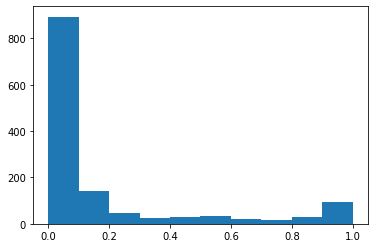

In [27]:
plt.hist(clfgnb.predict_proba(Xtest)[:,1])

Aha! At a 0.3 threshold we save more money!

We see that in this situation, where we have asymmetric costs, we do need to change the threshold at which we make our positive and negative predictions. We need to change the threshold so that we much dislike false negatives (same in the cancer case). Thus we must accept many more false positives by setting such a low threshold.

For otherwise, we let too many people slip through our hands who would have stayed with our telecom company given an incentive. But how do we pick this threshold?

In [28]:
from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5,  proba=True, skip=0, initial = False):
    if not ax:
        ax=plt.gca()
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', lw=2, alpha=0.4, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', lw=2, alpha=0.4, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in range(0, fpr.shape[0],labe):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

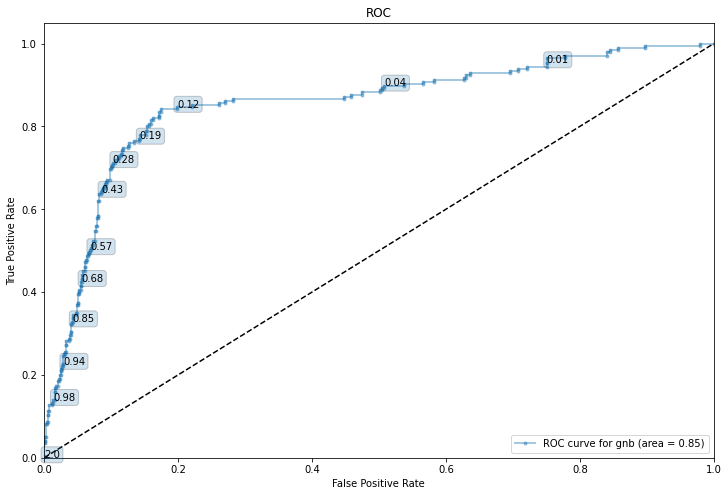

In [29]:
fig, ax = plt.subplots(figsize=(12,8))
make_roc("gnb",clfgnb, ytest, Xtest, ax=ax, labe=20, initial=True);

OK. Now that we have a ROC curve that shows us different thresholds, we need to figure how to pick the appropriate threshold from the ROC curve. But first, let us try another classifier.

#### Decision_Trees:

In [30]:
from sklearn.tree import DecisionTreeClassifier
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)
clfdt=DecisionTreeClassifier()
clfdt, Xtrain, ytrain, Xtest, ytest  = do_classify(clfdt, 
    {"max_depth": range(1,10,1), "min_samples_leaf": range(1, 20, 1)},
    dfchurn, colswewant_cont+colswewant_cat, 'Churn?', "True.", 
    reuse_split=reuse_split)

using reuse split
BEST {'max_depth': 6, 'min_samples_leaf': 4} 0.93496992481203
############# based on standard predict ################
Accuracy on training data: 0.96
Accuracy on test data:     0.95
[[1124   15]
 [  54  141]]
########################################################


In [31]:
confusion_matrix(ytest,clfdt.predict(Xtest))

array([[1124,   15],
       [  54,  141]])

#### Random_Forests:

In [32]:
from sklearn.ensemble import RandomForestClassifier
clfdt2=RandomForestClassifier()
clfdt2, Xtrain, ytrain, Xtest, ytest  = do_classify(clfdt2, 
    {"max_depth": range(1,10,1), "min_samples_leaf": range(1, 20, 1)},
    dfchurn, colswewant_cont+colswewant_cat, 'Churn?', "True.", 
    reuse_split=reuse_split,
    score_func="roc_auc")

using reuse split
SCORE FUNC roc_auc
BEST {'max_depth': 8, 'min_samples_leaf': 1} 0.9030030217916318
############# based on standard predict ################
Accuracy on training data: 0.97
Accuracy on test data:     0.95
[[1134    5]
 [  58  137]]
########################################################


### Comparison of ROC_AUC Curves:

How do we read which classifier is better from a ROC curve. The usual advice is to go to the North-West corner of a ROC curve, as that is closest to TPE=1, FPR=0. But thats not our setup here..we have this asymmetric data set. The other advice is to look at the classifier with the highest AUC.And then there is the question of figuring what threshold to choose as well. To answer both of these, we are going to have to turn back to cost

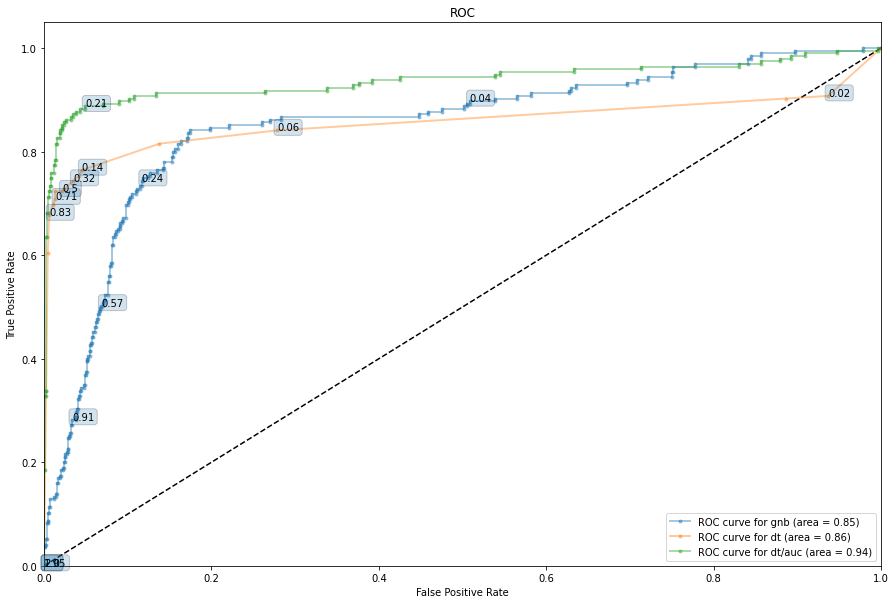

In [33]:
fig, ax = plt.subplots(figsize=(15,10))
make_roc("gnb",clfgnb, ytest, Xtest, ax=ax, labe=50, initial=True);
make_roc("dt",clfdt, ytest, Xtest, ax, labe=2)
make_roc("dt/auc",clfdt2, ytest, Xtest, ax, labe=50)

#### Reprediction again: Now with Cost or Risk

You can use the utility or cost matrix to provide a  threshold to pick for our classifier. 

The key idea is that we want to minimize cost on our test set, so for each sample, simply pick the class which does that. 

To understand this, lets follow through with a bit of math:


We simply weigh each combinations loss by the probability that that combination can happen:

$$ R_{g}(x) = \sum_y l(y,g(x)) p(y|x)$$

That is, we calculate the **average risk** over all choices y, of making choice g for a given sample.

Then, if we want to calculate the overall risk, given all the samples in our set, we calculate:

$$R(g) = \sum_x p(x) R_{g}(x)$$

It is sufficient to minimize the risk at each point or sample to minimize the overall risk since $p(x)$ is always positive.

Consider the two class classification case. Say we make a "decision g about which class" at a sample x. Then:

$$R_g(x) = l(1, g)p(1|x) + l(0, g)p(0|x).$$

Then for the "decision" $g=1$ we have:

$$R_1(x) = l(1,1)p(1|x) + l(0,1)p(0|x),$$

and for the "decision" $g=0$ we have:

$$R_0(x) = l(1,0)p(1|x) + l(0,0)p(0|x).$$

Now, we'd choose $1$ for the sample at $x$ if:

$$R_1(x) \lt R_0(x).$$

$$ P(1|x)(l(1,1) - l(1,0)) \lt p(0|x)(l(0,0) - l(0,1))$$

This gives us a ratio `r` between the probabilities to make a prediction. We assume this is true for all samples.

So, to choose '1':

$$p(1|x) \gt r P(0|x) \implies r=\frac{l(0,1) - l(0,0)}{l(1,0) - l(1,1)} =\frac{c_{FP} - c_{TN}}{c_{FN} - c_{TP}}$$

This may also be written as:

$$P(1|x) \gt t = \frac{r}{1+r}$$.

If you assume that True positives and True negatives have no cost, and the cost of a false positive is equal to that of a false positive, then $r=1$ and the threshold is the usual intutive $t=0.5$.

In [34]:
def rat(cost):
    return (cost[0,1] - cost[0,0])/(cost[1,0]-cost[1,1])

In [35]:
def c_repredict(est, c, xtest):
    r = rat(c)
    print(r)
    t=r/(1.+r)
    print("t=", t)
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 >= t)*1
    return ypred

In [36]:
average_cost(ytest, c_repredict(clfdt, cost, Xtest), cost)

0.23042505592841164
t= 0.18727272727272729


100.62593703148426

This value turns out to be only approximate, and we are better using a ROC curve or a Cost curve (below) to find minimum cost. However, it will get us in the right ballpark of the threshold we need. Note that the threshold itself depends only on costs and is independent of the classifier.

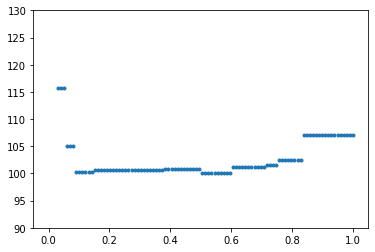

In [38]:
ts = np.linspace(0., 1., 100)
plt.plot(ts, [average_cost(ytest, repredict(clfdt, t, Xtest), cost) for t in ts], '.' )
plt.ylim(90, 130)
average_costing=list(zip(ts,[average_cost(ytest, repredict(clfdt, t, Xtest), cost) for t in ts]))

#### Model selection using ROC_AUC:

So one can use the tangent line method to find the classifier we ought to use and multiple questions about ROC curves now get answered.

(1) For a balanced data set, with equal misclassification costs, and no cost for true positives and true negatives, the slope is 1. Thus 45 degree lines are what we want, and hence closest to the north west corner, as thats where a 45 degree line would be tangent.
(2) Classifiers which have some part of their ROC curve closer to the northwest corner than others have tangent lines with higher intercepts and thus lower cost
(3) For any other case, find the line!

In [39]:
print(rat(cost))
slope = rat(cost)*(np.mean(ytest==0)/np.mean(ytest==1))
slope

0.23042505592841164


1.3459186600126198

In [40]:
z1=np.arange(0.,1., 0.02)
def plot_line(ax, intercept):
    plt.figure(figsize=(12,12))
    ax=plt.gca()
    ax.set_xlim([0.0,1.0])
    ax.set_ylim([0.0,1.0])
    make_roc("gnb",clfgnb, ytest, Xtest, ax, labe=60)
    make_roc("dt",clfdt, ytest, Xtest, ax, labe=2)
    ax.plot(z1 , slope*z1 + intercept, 'k-')

In [41]:
from IPython.html.widgets import interact, fixed
interact(plot_line, ax=fixed(ax), intercept=(0.0,1.0, 0.02))

/usr/local/lib/python3.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


interactive(children=(FloatSlider(value=0.5, description='intercept', max=1.0, step=0.02), Output()), _dom_cla…

<function __main__.plot_line(ax, intercept)>

As you can see our slope is actually on the rising part of the curve, even with the imbalance.

#### Cost_Curve:

The proof is always in the pudding. So far we have used a method to calculate a rough threshold from the cost/utility matrix, and seen the ROC curve which implements one classifier per threshold to pick an appropriate model. But why not just plot the cost/profit (per person) per threshold on a ROC like curve to see which classifier maximizes profit/minimizes cost? 

Just like in a ROC curve, we go down the sorted (by score or probability) list of samples. We one-by-one add an additional sample to our positive samples, noting down the attendant classifier's TPR and FPR and threshold. In addition to what we do for the ROC curve, we now also note down the percentage of our list of samples predicted as positive. Remember we start from the mostest positive, where the percentage labelled as positive would be minuscule, like 0.1 or so and the threshold like a 0.99 in probability or so. As we decrease the threshold, the percentage predicted to be positive clearly increases until everything is predicted positive at a threshold of 0. What we now do is, at each such additional sample/threshold (given to us by the `roc_curve` function from `sklearn`), we calculate the expected profit per person and plot it against the percentage predicted positive by that threshold to produce a profit curve. Thus, small percentages correspond to samples most likely to be positive: a percentage of 8% means the top 8% of our samples ranked by likelihood of being positive.

As in the ROC curve case, we use `sklearn`'s `roc_curve` function to return us a set of thresholds with TPRs and FPRs.

In [42]:
def percentage(tpr, fpr, priorp, priorn):
    perc = tpr*priorp + fpr*priorn
    return perc
def av_cost2(tpr, fpr, cost, priorp, priorn):
    profit = priorp*(cost[1][1]*tpr+cost[1][0]*(1.-tpr))+priorn*(cost[0][0]*(1.-fpr) +cost[0][1]*fpr)
    return profit
def plot_cost(name, clf, ytest, xtest, cost, ax=None, threshold=False, labe=200, proba=True):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    priorp=np.mean(ytest)
    priorn=1. - priorp
    ben=[]
    percs=[]
    for i,t in enumerate(thresholds):
        perc=percentage(tpr[i], fpr[i], priorp, priorn)
        ev = av_cost2(tpr[i], fpr[i], cost, priorp, priorn)
        ben.append(ev)
        percs.append(perc*100)
    ax.plot(percs, ben, '-', alpha=0.3, markersize=5, label='cost curve for %s' % name)
    if threshold:
        label_kwargs = {}
        label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
        )
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (percs[k], ben[k]), **label_kwargs)
    ax.legend(loc="lower right")
    return ax

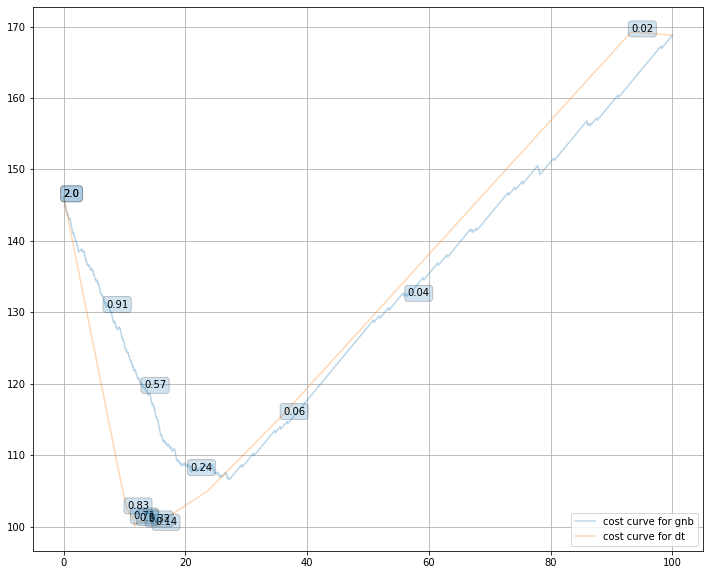

In [43]:
fig, ax = plt.subplots(figsize=(12,10))
ax = plot_cost("gnb",clfgnb, ytest, Xtest, cost, ax=ax, threshold=True, labe=50);
plot_cost("dt",clfdt, ytest, Xtest, cost, ax, threshold=True, labe=2);
ax.grid()

##### Note the customers on the left of this graph are most likely to churn (be positive).

This if you had a finite budget, you should be targeting them!

Finding the best classifier has a real consequence: you save money!!!

In [45]:
costmaker = lambda f: np.array([[tnc, fpc],[fnc, f*(offer_cost+admin_cost) + (1. - f)*(clv+admin_cost)]])

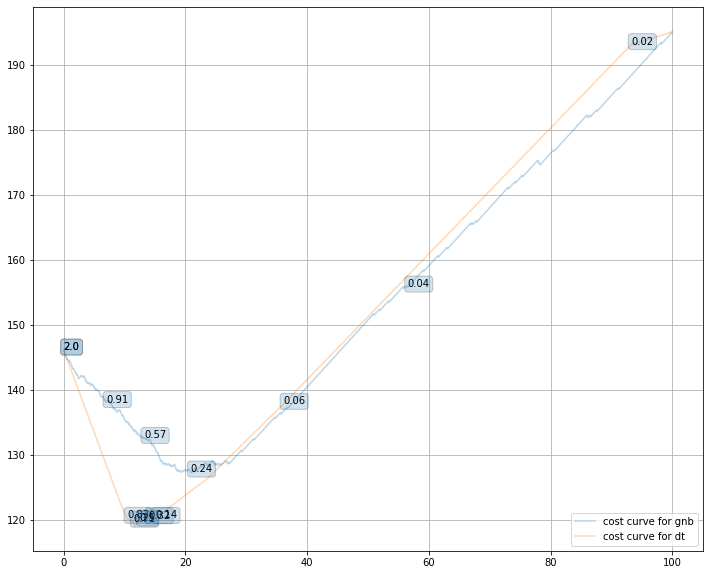

In [46]:
fig, ax = plt.subplots(figsize=(12,10))
ax = plot_cost("gnb",clfgnb, ytest, Xtest, costmaker(0.3), ax=ax, threshold=True, labe=50);
plot_cost("dt",clfdt, ytest, Xtest, costmaker(0.3), ax, threshold=True, labe=2);
ax.grid()

The above graph is a snapshot of a run. One thing worth noticing is that classifiers perform differently in different regions. If you targeted only the top 20% of your users..and these are the ones most likely to churn so you should target them first, you would want to use the decision-tree classifier. And you might only get to target these top 20 given your budget. Remember that there is a cost associated with targeting predicted positives. That cost can be read of the graph above. Say we had a million customers. Now, at 10%, or 100,000 we are talking about a minimum budget of 10.3 million dollars. 

If 10-15 million is your budget, then you use the decision tree classifier on your left. If 40-60 million is your budget, roughly, you would use the gnb classifier instead.